------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [15]:
!python --version

Python 3.11.5


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [17]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [18]:
import re
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import seaborn as sns

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [20]:
# Downloading sent_lexicon (Windows)
!curl -s -o sent_lexicon https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon

# Downloading reviews.json (Windows)
!curl -s -o reviews.json https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

In [21]:
# download sentiment lexicon
#!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
#!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [23]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

### (1) Lexicon-based approach (3.5pts) ###

A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [26]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
     loaded_line = line.strip()
     print(line)
     print(loaded_line)
     print()
     line_cnt += 1
     if line_cnt > 4:
       break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative

type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative



Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [29]:
# Extracting a word-sentiment dictionary from the provided lexicon
with open("sent_lexicon", mode="r", encoding="utf-8") as lexicon:
    word_polarity_dict = {}
    
    for i, line in enumerate(lexicon):
        loaded_line = line.strip()
        parts = loaded_line.split()

        # Initialize pair variables for the dictionary
        word = None
        priorpolarity = None

        # Using string methods to locate and extract words and sentiment labels
        for part in parts:
            if part.startswith('word1='):
                word = part.split('word1=')[1]
            if part.startswith('priorpolarity='):
                priorpolarity = part.split('priorpolarity=')[1]

        if word and priorpolarity and word not in word_polarity_dict:
            word_polarity_dict[word] = priorpolarity

In [30]:
# Inspect the set of sentiment labels in the lexicon
print(set(word_polarity_dict.values()))

{'neutral', 'negative', 'positive', 'both'}


In [31]:
# YOUR CODE HERE
with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)
    # Prepare a set pos tags of special bracket markers
    bracket_pos = ['-LRB-', '-RRB-']
    # Initialize a list of final scores and a list of ground-truth labels
    final_score_list = []
    gold_label_list = []

    # Loop over every review unit 
    for i, unit in enumerate(reviews):
        # first retrieve sentiment labels and store in a list
        unit_gold = unit['sentiment']
        gold_label_list.append(unit_gold)

        # Then retrieve the list of sentences in
        # the current review unit and store them in a list
        unit_sentence_list = unit['content']
        # Initialize a word list and a sentiment score variable
        unit_word_list = []
        sentiment_score = 0

        # Loop over every sentence in the current review unit
        for sentence_word_list in unit_sentence_list:
            # further loop over every word-pos pair in a sentence
            for word, pos in sentence_word_list:
                # only collect words that are with alphabetic letters (ruling out punctuations)
                # and also exclude special bracket markers
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    # lower-case them and add them to the word list of the current review unit
                    unit_word_list.append(word.lower())            

        # Loop over every word in the word list of the current review unit
        for word in unit_word_list:
            # Checking if they are in the lexicon
            if word in word_polarity_dict:
                # return positive, sentiment score + 1
                if word_polarity_dict[word] == 'positive':
                    sentiment_score += 1
                # return negative, sentiment score - 1
                elif word_polarity_dict[word] == 'negative':
                    sentiment_score += -1
                # return other labels, sentiment score doesn't change
                else:
                    sentiment_score += 0
            # if the word is not in the lexicon, sentiment score doesn't change
            else:
                sentiment_score += 0

        # Add results per review unit to a list
        final_score_list.append(sentiment_score)

In [32]:
# Convert the score list into a label list using the provided threshold
converted_tag_list = ['POS' if score > 8 else 'NEG' for score in final_score_list]

In [33]:
print(len(final_score_list))
print(len(gold_label_list))
print(len(converted_tag_list))

2000
2000
2000


In [34]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = [1 if label == gold_label_list[i] else 0 for i, label in enumerate(converted_tag_list)]
token_accuracy = round(((token_results.count(1)/len(token_results))*100), 2)
print(f"Accuracy: {token_accuracy}%")

Accuracy: 68.5%


In [35]:
# Define a function for the above accuracy report
def accuracy_report(gold, predictions):
    results = [1 if label == gold[i] else 0 for i, label in enumerate(predictions)]
    accuracy = round(((results.count(1)/len(results))*100), 2)
    return results, accuracy

As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [37]:
# Inspecting all possible labels of "type" (magnitude labels) in the lexicon
with open("sent_lexicon", mode="r", encoding="utf-8") as lexicon:
    mag_label = []
    
    for i, line in enumerate(lexicon):
        loaded_line = line.strip()
        parts = loaded_line.split()

        for part in parts:
            if part.startswith('type='):
                label = part.split('type=')[1]
                mag_label.append(label)

mag_set = set(mag_label)
print(mag_set)

{'weaksubj', 'strongsubj'}


In [38]:
# YOUR CODE HERE
# Adjust the codes to include magnitude in lexicon labels
with open("sent_lexicon", mode="r", encoding="utf-8") as lexicon:
    word_polarity_dict_mag = {}
    
    for i, line in enumerate(lexicon):
        loaded_line = line.strip()
        parts = loaded_line.split()

        word = None
        priorpolarity = None

        for part in parts:
            if part.startswith('word1='):
                word = part.split('word1=')[1]
            if part.startswith('priorpolarity='):
                priorpolarity = part.split('priorpolarity=')[1]
            if part.startswith('type='):
                magnitude = part.split('type=')[1][:-4]

        if word and priorpolarity and word not in word_polarity_dict_mag:
            word_polarity_dict_mag[word] = magnitude +' '+ priorpolarity

In [39]:
# All possible lexicon labels after including magnitude
print(set(word_polarity_dict_mag.values()))

{'weak negative', 'strong positive', 'weak neutral', 'weak both', 'strong negative', 'strong both', 'weak positive', 'strong neutral'}


In [40]:
with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)
    bracket_pos = ['-LRB-', '-RRB-']
    final_score_list = []
    gold_label_list = []
    

    for i, unit in enumerate(reviews):
        unit_gold = unit['sentiment']
        gold_label_list.append(unit_gold)
        
        unit_sentence_list = unit['content']
        unit_word_list = []
        sentiment_score = 0
        
        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())            

        # Adjust the checking conditions as magnitude info is included
        # Using a weighted scoring system to differentiate the magnitude
        for word in unit_word_list:
            if word in word_polarity_dict_mag:
                if word_polarity_dict_mag[word] == 'strong positive':
                    sentiment_score += 2
                elif word_polarity_dict_mag[word] == 'weak positive':
                    sentiment_score += 1
                elif word_polarity_dict_mag[word] == 'strong negative':
                    sentiment_score += -2
                elif word_polarity_dict_mag[word] == 'weak negative':
                    sentiment_score += -1
                else:
                    sentiment_score += 0

            else:
                sentiment_score += 0
                    
        final_score_list.append(sentiment_score)         

Since the weighted scoring system is newly defined, the originally provided threshold is no longer appropriate. We still follow the spirit of setting a threshold around the value of "how many more positive than negative per review" for a new threshold in this case. Observing that the (positive) average score value computed from scores of all review units roughly reveals "how many more positive than negative per review" in general in our sample, so we take a value around this average score as the new threshold.

In [42]:
print(len(final_score_list))
avg_threshold_m = sum(final_score_list)/len(final_score_list)
print(avg_threshold_m)
magnitude_threshold = int(avg_threshold_m)+1
print(magnitude_threshold)

2000
10.517
11


In [43]:
converted_tag_list_magnitude = ['POS' if score > magnitude_threshold else 'NEG' for score in final_score_list]

In [44]:
magnitude_results, accuracy_maginitude = accuracy_report(gold_label_list, converted_tag_list_magnitude)

In [45]:
print(f"The accuracy: {accuracy_maginitude}%")

The accuracy: 68.85%


#### (Q.1.3) Make a barplot of the two results (0.5pt)

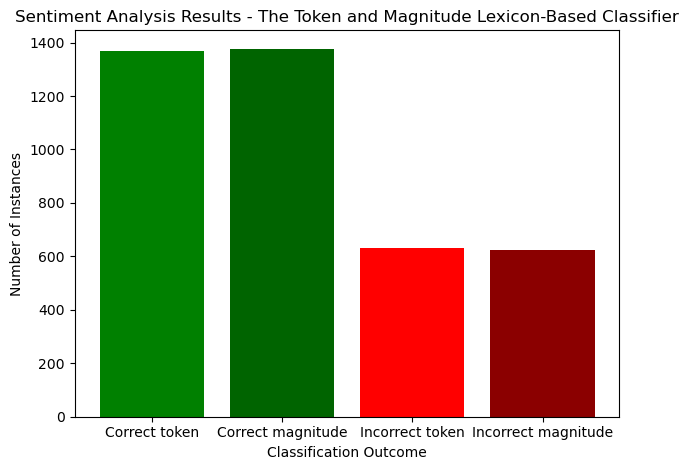

In [47]:
# The barplot for the magnitude lexicon-based classifier
correct_count_token = token_results.count(1)
incorrect_count_token = token_results.count(0)
correct_count_m = magnitude_results.count(1)
incorrect_count_m = magnitude_results.count(0)

categories = ['Correct token', 'Correct magnitude', 'Incorrect token', 'Incorrect magnitude']
counts = [correct_count_token, correct_count_m, incorrect_count_token, incorrect_count_m]


plt.bar(categories, counts, color=['green', 'darkgreen', 'red', 'darkred'])
plt.title('Sentiment Analysis Results - The Token and Magnitude Lexicon-Based Classifier')
plt.xlabel('Classification Outcome')
plt.ylabel('Number of Instances')
plt.tight_layout()
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

If the document length is not taken into account, it can be difficult for shorter reviews to be classified as "positive". This is because the shorter length would make it difficult for short reviews to include a enough number of positive words to reach the threshold of being claissified as "positive". As a result, although some short reviews may be highly positive in their tone, they may still be classified as "negative", causing an unwanted bias. In the following code, we simply normalize the sentiment score by the length of a review to reduce this bias.

In [50]:
# YOUR CODE HERE
with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)
    bracket_pos = ['-LRB-', '-RRB-']
    final_normalized_score_list = []
    gold_label_list = []
    

    for i, unit in enumerate(reviews):
        unit_gold = unit['sentiment']
        gold_label_list.append(unit_gold)
        
        unit_length = len(unit)
        
        unit_sentence_list = unit['content']
        unit_word_list = []
        sentiment_score = 0
        
        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())            
        
        for word in unit_word_list:
            if word in word_polarity_dict_mag:
                if word_polarity_dict_mag[word] == 'strong positive':
                    sentiment_score += 2
                elif word_polarity_dict_mag[word] == 'weak positive':
                    sentiment_score += 1
                elif word_polarity_dict_mag[word] == 'strong negative':
                    sentiment_score += -2
                elif word_polarity_dict_mag[word] == 'weak negative':
                    sentiment_score += -1
                else:
                    sentiment_score += 0

            else:
                sentiment_score += 0

        # The normalization to reduce the effect of review length
        normalized_score = sentiment_score / unit_length
        final_normalized_score_list.append(normalized_score)

In [51]:
print(len(final_normalized_score_list))

2000


In [52]:
normalized_threshold = int(sum(final_normalized_score_list)/len(final_normalized_score_list))+1
print(normalized_threshold)

4


In [53]:
converted_tag_list_normalized = ['POS' if score > normalized_threshold else 'NEG' for score in final_normalized_score_list]

In [54]:
results, accuracy = accuracy_report(gold_label_list, converted_tag_list_normalized)
print(f"Accuracy: {accuracy}%")

Accuracy: 68.6%


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

*Write your answer here.*

If we skip words only for one class in case 2, then the likelihood of these words would participate in the sum of log-likelihood as a part of the following computation for **only one** class before the final comparison and prediction:

$$ \log P(c_n)+ \sum_{i\in\text{positions}} P(w_i|c_n) $$

Then this would affect the prediction in an imbalanced way, as the result value of the class where the words are not skipped would be bigger and the final prediction would be biased to this class.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [60]:
# YOUR CODE HERE
# The basic-version NB classifier without smoothing
# The data preprocessiing
def create_train_test(reviews):
    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i, unit in enumerate(reviews):
        unit_sentence_list = unit['content']
        unit_cv = unit['cv']
        unit_sentiment = unit['sentiment']
        
        # The training set
        if 0 <= unit_cv <= 899:
            unit_word_list = []  
            train_sentiments.append(unit_sentiment)
            
            for sentence_word_list in unit_sentence_list:
                for word, pos in sentence_word_list:
                    if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                        unit_word_list.append(word.lower())

            train_reviews.append(unit_word_list)

        # The test set
        elif 900 <= unit_cv <= 999:
            unit_word_list = []  
            test_sentiments.append(unit_sentiment)

            for sentence_word_list in unit_sentence_list:
                for word, pos in sentence_word_list:
                    if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                        unit_word_list.append(word.lower())

            test_reviews.append(unit_word_list)
    
    return train_reviews, train_sentiments, test_reviews, test_sentiments

In [61]:
train_reviews, train_sentiments, test_reviews, test_sentiments = create_train_test(reviews)
print(len(train_reviews))
print(len(test_reviews))

1800
200


In [62]:
# Construct the grand vocabulary set V
vocabulary = set()

for review_word_list in train_reviews:
    vocabulary.update(review_word_list)

vocabulary = sorted(list(vocabulary))
print(len(vocabulary))

44812


In [63]:
# The training part in the pseudo-code
# N = CountDoc
N = len(train_reviews)

sentiment_counts = defaultdict(int) # initialize a default dict

# Collect N_pos and N_neg
for sentiment in train_sentiments:
    sentiment_counts[sentiment] += 1

# Prior[pos] and Prior[neg] - P(c)
prior_pos = sentiment_counts['POS']/N
prior_neg = sentiment_counts['NEG']/N

# A nested dict - outer key are sentiments, 
# values are with counters (inner dicts) for each word occur in the sentiment
word_counts_per_sentiment = defaultdict(Counter) 
total_word_counts = defaultdict(int) # A default dict of sentiment: total word count

for review, sentiment in zip(train_reviews, train_sentiments):
    word_counts_per_sentiment[sentiment].update(review) # count(w_i,c)
    total_word_counts[sentiment] += len(review) #\sum_{w\in V} count(w,c), total num of words of text_c

conditional_prob = defaultdict(lambda:defaultdict(float))
for sentiment, word_counts in word_counts_per_sentiment.items():
    total_words_sentiment = total_word_counts[sentiment] # retrieve the corresponding \sum_{w\in V} count(w,c)
    for word in vocabulary: # for each t \in V
        if total_words_sentiment != 0: # avoid deviding by 0
            conditional_prob[word][sentiment] = word_counts[word]/total_words_sentiment # count(w_i,c) / \sum_{w\in V} count(w,c), or T_{ct}/\sum T_{ct}
            # The learned P(w_i|c) are in place
            

In [64]:
# The applying part in the pseudo-code
predictions = []
# Put prior probabilities in a dictionary for easier dynamic reference
priors = {'POS':prior_pos, 'NEG':prior_neg}

# Introduce a progress bar for the loop
for review in tqdm(test_reviews, desc="Classifying reviews"):
    # Initialize a dictionary to store P(review|c_pos) and P(review|c_neg)
    # for convenient comparison later
    scores = dict() 

    # Loop over 2 sentiments
    for sentiment in priors.keys():
        score = math.log(priors[sentiment]) # log P(c)

        for word in review:
            # Ignore words not seen in the training set and exclude 
            # words of which the conditional prob is 0
            if word in vocabulary and conditional_prob[word][sentiment] != 0:
                score += math.log(conditional_prob[word][sentiment])

        scores[sentiment] = score 

    # The prediction for a review is the higher score (argmax logP(c)+\sum logP(w_i|c)
    predicted_sentiment_review = max(scores,key=scores.get)
    predictions.append(predicted_sentiment_review)

Classifying reviews: 100%|███████████████████████████████████████████████████████████| 200/200 [03:57<00:00,  1.19s/it]


In [65]:
NB1_results, NB1_accuracy = accuracy_report(test_sentiments, predictions)
NB1_results = [1 if label == test_sentiments[i] else 0 for i, label in enumerate(predictions)]# a list of binary indicators
print(f"Accuracy: {NB1_accuracy}%")

Accuracy: 50.0%


In [66]:
# Encapsule the training and testing into a function, 
# but changed to using np arrays for faster computation

def Naive_Bayes_classifier(training_texts, training_labels, testing_texts):
    # Build vocabulary
    vocabulary = set()
    for review in training_texts:
        vocabulary.update(review)
    vocabulary = sorted(list(vocabulary))
    vocab_size = len(vocabulary)

    # Convert vocabulary to indices for numpy operations
    vocab_index = {word: i for i, word in enumerate(vocabulary)}
    label_set = sorted(set(training_labels))
    label_index = {label: i for i, label in enumerate(label_set)}

    # Initialize arrays for word counts and label counts
    word_counts = np.zeros((len(label_set), vocab_size))
    label_counts = np.zeros(len(label_set))


    # Count word occurrences per label
    for review, label in zip(training_texts, training_labels):
        label_id = label_index[label]
        label_counts[label_id] += 1
        for word in review:
            if word in vocab_index:
                word_counts[label_id, vocab_index[word]] += 1

    # Calculate prior probabilities
    prior_probs = label_counts / len(training_texts)

    # Calculate conditional probabilities
    conditional_probs = word_counts / word_counts.sum(axis=1, keepdims=True)

    # Classify test samples
    predictions = []
    for review in tqdm(testing_texts, desc="Classifying reviews"):
        scores = []
        for label_id, label in enumerate(label_set):
            # Start with log prior probability
            score = math.log(prior_probs[label_id])

            # Add log probabilities of words in the review
            for word in review:
                # skip words that were not seen during training
                if word in vocab_index:
                    word_prob = conditional_probs[label_id, vocab_index[word]]
                    # avoid log(0)L
                    if word_prob > 0:
                        score += math.log(word_prob)
            scores.append(score)

        # Choose the label with the highest score
        best_label_id = np.argmax(scores)
        predictions.append(label_set[best_label_id])

    return predictions


In [67]:
NB_predictions = Naive_Bayes_classifier(train_reviews, train_sentiments, test_reviews)

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1470.61it/s]


In [68]:
results, accuracy = accuracy_report(test_sentiments, NB_predictions)
print(f"Accuracy: {accuracy}%")

Accuracy: 50.0%


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.


The accuracy drops dramatically, because the classifier only witnesses most word tokens under the positive sentiment label and their probabilities given a negative label are 0 or really low. Therefore, the classifier would be heavily biased towards predicting the positive label, and this greatly damages the accuracy. The low accuracy is an indirect result of this problem, the problem is more directly revealed in the recall.

In [71]:
# YOUR CODE HERE
# The data preprocessiing for the unbalancing experiment
train_reviews_exp = []
train_sentiments_exp = []
test_reviews_exp = []
test_sentiments_exp = []

for i, unit in enumerate(reviews):
    unit_sentence_list = unit['content']
    unit_cv = unit['cv']
    unit_sentiment = unit['sentiment']
    
    # The training set
    if 0 <= unit_cv <= 899 and unit_sentiment == 'POS':
        unit_word_list = []  
        train_sentiments_exp.append(unit_sentiment)
        
        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())

        train_reviews_exp.append(unit_word_list)

    elif 0 <= unit_cv <= 89 and unit_sentiment == 'NEG':
        unit_word_list = []  
        train_sentiments_exp.append(unit_sentiment)
        
        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())

        train_reviews_exp.append(unit_word_list)

    # The test set
    elif 900 <= unit_cv <= 999 and unit_sentiment == 'POS':
        unit_word_list = []  
        test_sentiments_exp.append(unit_sentiment)

        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())

        test_reviews_exp.append(unit_word_list)

    elif 900 <= unit_cv <= 909 and unit_sentiment == 'NEG':
        unit_word_list = []  
        test_sentiments_exp.append(unit_sentiment)

        for sentence_word_list in unit_sentence_list:
            for word, pos in sentence_word_list:
                if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                    unit_word_list.append(word.lower())

        test_reviews_exp.append(unit_word_list)

In [72]:
print(len(train_reviews_exp))
print(len(test_reviews_exp))

990
110


In [73]:
predictions_exp = Naive_Bayes_classifier(train_reviews_exp, train_sentiments_exp, test_reviews_exp)

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 1478.79it/s]


In [74]:
results, accuracy = accuracy_report(test_sentiments_exp, predictions_exp)
print(f"Accuracy: {accuracy}%")

Accuracy: 9.09%


A supplementary cross-validation for the final data analysis

In [76]:
def unit_word_list(unit_sentence_list, unit_sentiment):
    unit_word_list = []
            
    for sentence_word_list in unit_sentence_list:
        for word, pos in sentence_word_list:
            if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                unit_word_list.append(word.lower())

    return unit_sentiment, unit_word_list


def round_robin_splitting(reviews):
    split1, split2, split3, split4, split5, split6, split7, split8, split9, split10 = ([] for i in range(10))

    for i, unit in enumerate(reviews):
        unit_sentence_list = unit['content']
        unit_cv = unit['cv']
        unit_sentiment = unit['sentiment']
        
        if unit_cv % 10 == 0:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split1.append([sentiment, review])
            
        elif unit_cv % 10 == 1:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split2.append([sentiment, review])

        elif unit_cv % 10 == 2:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split3.append([sentiment, review])

        elif unit_cv % 10 == 3:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split4.append([sentiment, review])

        elif unit_cv % 10 == 4:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split5.append([sentiment, review])

        elif unit_cv % 10 == 5:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split6.append([sentiment, review])

        elif unit_cv % 10 == 6:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split7.append([sentiment, review])
        
        elif unit_cv % 10 == 7:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split8.append([sentiment, review])

        elif unit_cv % 10 == 8:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split9.append([sentiment, review])
        
        elif unit_cv % 10 == 9:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split10.append([sentiment, review])

    return split1, split2, split3, split4, split5, split6, split7, split8, split9, split10

with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)   # each split is a list which has items that are a list of sentiment, review  


def Naive_Bayes_basic_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = Naive_Bayes_classifier(train_reviews, train_sentiments, test_reviews)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy

In [77]:
def calc_cross_val_score_basicNB():
    total_accuracy = []

    results_s1, accuracy_s1 = Naive_Bayes_basic_on_split(s1, [s2, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 1: {accuracy_s1}%")
    total_accuracy.append(accuracy_s1)

    results_s2, accuracy_s2 = Naive_Bayes_basic_on_split(s2, [s1, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 2: {accuracy_s2}%")
    total_accuracy.append(accuracy_s2)

    results_s3, accuracy_s3 = Naive_Bayes_basic_on_split(s3, [s2, s1, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 3: {accuracy_s3}%")
    total_accuracy.append(accuracy_s3)

    results_s4, accuracy_s4 = Naive_Bayes_basic_on_split(s4, [s2, s3, s1, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 4: {accuracy_s4}%")
    total_accuracy.append(accuracy_s4)

    results_s5, accuracy_s5 = Naive_Bayes_basic_on_split(s5, [s2, s3, s4, s1, s6, s7, s8, s9, s10])
    print(f"Accuracy split 5: {accuracy_s5}%")
    total_accuracy.append(accuracy_s5)

    results_s6, accuracy_s6 = Naive_Bayes_basic_on_split(s6, [s2, s3, s4, s5, s1, s7, s8, s9, s10])
    print(f"Accuracy split 6: {accuracy_s6}%")
    total_accuracy.append(accuracy_s6)

    results_s7, accuracy_s7 = Naive_Bayes_basic_on_split(s7, [s2, s3, s4, s5, s6, s1, s8, s9, s10])
    print(f"Accuracy split 7: {accuracy_s7}%")
    total_accuracy.append(accuracy_s7)

    results_s8, accuracy_s8 = Naive_Bayes_basic_on_split(s8, [s2, s3, s4, s5, s6, s7, s1, s9, s10])
    print(f"Accuracy split 8: {accuracy_s8}%")
    total_accuracy.append(accuracy_s8)

    results_s9, accuracy_s9 = Naive_Bayes_basic_on_split(s9, [s2, s3, s4, s5, s6, s7, s8, s1, s10])
    print(f"Accuracy split 9: {accuracy_s9}%")
    total_accuracy.append(accuracy_s9)

    results_s10, accuracy_s10 = Naive_Bayes_basic_on_split(s10, [s2, s3, s4, s5, s6, s7, s8, s9, s1])
    print(f"Accuracy split 10: {accuracy_s10}%")
    total_accuracy.append(accuracy_s10)

    return total_accuracy

In [78]:
# initialize a dataframe to be able to store accuracy data for discussion question
df_accuracies = pd.DataFrame(columns=['model', 'accuracy'])

In [79]:
total_accuracy = calc_cross_val_score_basicNB()
mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

variance = sum((acc - mean_accuracy) ** 2 for acc in total_accuracy) / len(total_accuracy)

print(f"Variance is {variance}")

for i in total_accuracy:
    list_row = ["Basic Naive Bayes", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1451.65it/s]


Accuracy split 1: 51.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1416.67it/s]


Accuracy split 2: 48.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1222.63it/s]


Accuracy split 3: 47.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1505.91it/s]


Accuracy split 4: 48.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1559.80it/s]


Accuracy split 5: 41.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1405.99it/s]


Accuracy split 6: 45.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1345.03it/s]


Accuracy split 7: 51.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1523.25it/s]


Accuracy split 8: 52.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 954.75it/s]


Accuracy split 9: 51.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1512.67it/s]

Accuracy split 10: 44.5%
Accuracy total: 48.15%
Variance is 11.1525


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [82]:
# Encapsule the training and testing into a function, 
# but changed to using np arrays for faster computation

def Naive_Bayes_classifier_laplace(training_texts, training_labels, testing_texts):
    # Build vocabulary
    vocabulary = set()
    for review in training_texts:
        vocabulary.update(review)
    vocabulary = sorted(list(vocabulary))
    vocab_size = len(vocabulary)

    # Convert vocabulary to indices for numpy operations
    vocab_index = {word: i for i, word in enumerate(vocabulary)}
    label_set = sorted(set(training_labels))
    label_index = {label: i for i, label in enumerate(label_set)}

    # Initialize arrays for word counts and label counts
    word_counts = np.ones((len(label_set), vocab_size))
    label_counts = np.zeros(len(label_set))


    # Count word occurrences per label
    for review, label in zip(training_texts, training_labels):
        label_id = label_index[label]
        label_counts[label_id] += 1
        for word in review:
            if word in vocab_index:
                word_counts[label_id, vocab_index[word]] += 1

    # Calculate prior probabilities
    prior_probs = label_counts / len(training_texts)

    # Calculate conditional probabilities
    conditional_probs = word_counts / word_counts.sum(axis=1, keepdims=True)

    # Classify test samples
    predictions = []
    for review in tqdm(testing_texts, desc="Classifying reviews"):
        scores = []
        for label_id, label in enumerate(label_set):
            # Start with log prior probability
            score = math.log(prior_probs[label_id])

            # Add log probabilities of words in the review
            for word in review:
                # skip words that were not seen during training
                if word in vocab_index:
                    word_prob = conditional_probs[label_id, vocab_index[word]]
                    score += math.log(word_prob)
            scores.append(score)

        # Choose the label with the highest score
        best_label_id = np.argmax(scores)
        predictions.append(label_set[best_label_id])

    return predictions


In [83]:
smoothed_predictions = Naive_Bayes_classifier_laplace(train_reviews, train_sentiments, test_reviews)

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1615.46it/s]


In [84]:
results, accuracy = accuracy_report(test_sentiments, smoothed_predictions)
print(f"Accuracy: {accuracy}%")

Accuracy: 82.5%


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [87]:
def unit_word_list(unit_sentence_list, unit_sentiment):
    unit_word_list = []
            
    for sentence_word_list in unit_sentence_list:
        for word, pos in sentence_word_list:
            if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                unit_word_list.append(word.lower())

    return unit_sentiment, unit_word_list


def round_robin_splitting(reviews):
    split1, split2, split3, split4, split5, split6, split7, split8, split9, split10 = ([] for i in range(10))

    for i, unit in enumerate(reviews):
        unit_sentence_list = unit['content']
        unit_cv = unit['cv']
        unit_sentiment = unit['sentiment']
        
        if unit_cv % 10 == 0:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split1.append([sentiment, review])
            
        elif unit_cv % 10 == 1:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split2.append([sentiment, review])

        elif unit_cv % 10 == 2:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split3.append([sentiment, review])

        elif unit_cv % 10 == 3:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split4.append([sentiment, review])

        elif unit_cv % 10 == 4:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split5.append([sentiment, review])

        elif unit_cv % 10 == 5:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split6.append([sentiment, review])

        elif unit_cv % 10 == 6:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split7.append([sentiment, review])
        
        elif unit_cv % 10 == 7:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split8.append([sentiment, review])

        elif unit_cv % 10 == 8:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split9.append([sentiment, review])
        
        elif unit_cv % 10 == 9:
            sentiment, review = unit_word_list(unit_sentence_list, unit_sentiment)
            split10.append([sentiment, review])

    return split1, split2, split3, split4, split5, split6, split7, split8, split9, split10

with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)   # each split is a list which has items that are a list of sentiment, review  

def Naive_Bayes_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = Naive_Bayes_classifier_laplace(train_reviews, train_sentiments, test_reviews)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy


In [88]:
def calc_cross_val_score():
    total_accuracy = []

    results_s1, accuracy_s1 = Naive_Bayes_on_split(s1, [s2, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 1: {accuracy_s1}%")
    total_accuracy.append(accuracy_s1)

    results_s2, accuracy_s2 = Naive_Bayes_on_split(s2, [s1, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 2: {accuracy_s2}%")
    total_accuracy.append(accuracy_s2)

    results_s3, accuracy_s3 = Naive_Bayes_on_split(s3, [s2, s1, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 3: {accuracy_s3}%")
    total_accuracy.append(accuracy_s3)

    results_s4, accuracy_s4 = Naive_Bayes_on_split(s4, [s2, s3, s1, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 4: {accuracy_s4}%")
    total_accuracy.append(accuracy_s4)

    results_s5, accuracy_s5 = Naive_Bayes_on_split(s5, [s2, s3, s4, s1, s6, s7, s8, s9, s10])
    print(f"Accuracy split 5: {accuracy_s5}%")
    total_accuracy.append(accuracy_s5)

    results_s6, accuracy_s6 = Naive_Bayes_on_split(s6, [s2, s3, s4, s5, s1, s7, s8, s9, s10])
    print(f"Accuracy split 6: {accuracy_s6}%")
    total_accuracy.append(accuracy_s6)

    results_s7, accuracy_s7 = Naive_Bayes_on_split(s7, [s2, s3, s4, s5, s6, s1, s8, s9, s10])
    print(f"Accuracy split 7: {accuracy_s7}%")
    total_accuracy.append(accuracy_s7)

    results_s8, accuracy_s8 = Naive_Bayes_on_split(s8, [s2, s3, s4, s5, s6, s7, s1, s9, s10])
    print(f"Accuracy split 8: {accuracy_s8}%")
    total_accuracy.append(accuracy_s8)

    results_s9, accuracy_s9 = Naive_Bayes_on_split(s9, [s2, s3, s4, s5, s6, s7, s8, s1, s10])
    print(f"Accuracy split 9: {accuracy_s9}%")
    total_accuracy.append(accuracy_s9)

    results_s10, accuracy_s10 = Naive_Bayes_on_split(s10, [s2, s3, s4, s5, s6, s7, s8, s9, s1])
    print(f"Accuracy split 10: {accuracy_s10}%")
    total_accuracy.append(accuracy_s10)

    return total_accuracy

#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [90]:
total_accuracy = calc_cross_val_score()
mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

variance = sum((acc - mean_accuracy) ** 2 for acc in total_accuracy) / len(total_accuracy)

print(f"Variance is {variance}")

for i in total_accuracy:
    list_row = ["Naive Bayes Laplace", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1749.85it/s]


Accuracy split 1: 78.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1548.85it/s]


Accuracy split 2: 83.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1610.53it/s]


Accuracy split 3: 80.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1685.96it/s]


Accuracy split 4: 82.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1787.39it/s]


Accuracy split 5: 79.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1682.71it/s]


Accuracy split 6: 84.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1582.90it/s]


Accuracy split 7: 82.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1671.15it/s]


Accuracy split 8: 78.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1734.74it/s]


Accuracy split 9: 83.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1649.28it/s]

Accuracy split 10: 82.0%
Accuracy total: 81.4%
Variance is 4.589999999999999


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [93]:
stemmer = PorterStemmer()

# by only adjusting this function, we will use the stemmed versions of the reviews instead of the normal ones
def unit_word_list(unit_sentence_list, unit_sentiment):
    unit_word_list = []
            
    for sentence_word_list in unit_sentence_list:
        for word, pos in sentence_word_list:
            if re.search(r'[A-Za-z]', word) and pos not in bracket_pos:
                unit_word_list.append(stemmer.stem(word.lower()))

    return unit_sentiment, unit_word_list

s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)   # each split is a list which has items that are a list of sentiment, review  



def Naive_Bayes_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = Naive_Bayes_classifier_laplace(train_reviews, train_sentiments, test_reviews)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [95]:
total_accuracy = calc_cross_val_score()
mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

variance = sum((acc - mean_accuracy) ** 2 for acc in total_accuracy) / len(total_accuracy)

print(f"Variance is {variance}")

for i in total_accuracy:
    list_row = ["Naive Bayes stemming", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1719.75it/s]


Accuracy split 1: 78.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1605.37it/s]


Accuracy split 2: 82.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1661.55it/s]


Accuracy split 3: 80.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1615.20it/s]


Accuracy split 4: 83.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1829.17it/s]


Accuracy split 5: 79.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1679.16it/s]


Accuracy split 6: 83.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1602.57it/s]


Accuracy split 7: 84.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1676.21it/s]


Accuracy split 8: 76.0%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1736.11it/s]


Accuracy split 9: 84.5%


Classifying reviews: 100%|█████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1750.12it/s]

Accuracy split 10: 82.5%
Accuracy total: 81.4%
Variance is 7.489999999999999


For some splits using stemming works better, but for some splits using stemming works worse. The overall accuracy is exactly the same; the variance is bigger. We expected stemming to give a better performance because it makes the data less sparse. However, the stemming did however not change the overall accuracy. There can be a tradeoff between the effects brought by the stemming. From one aspect, stemming can help with the dimension reduction for feature vectors, so that the vectors are less sparse and the system can focus on important features and clearer patterns; but on the other hand, this measure may also disregard some specific features (i.e. some specific word forms) that may be loaded with some patterns that are important for the sentiment analysis task.

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [98]:
training_texts, _, _, _ = create_train_test(reviews)

vocabulary = set()
for word_list in training_texts:
    stemmer_word_list = [stemmer.stem(word) for word in word_list]
    vocabulary.update(stemmer_word_list)

vocabulary = sorted(list(vocabulary))
len_stemmed_voc = len(vocabulary)
    
vocabulary = set()

for word_list in training_texts:
    vocabulary.update(word_list)

vocabulary = sorted(list(vocabulary))
len_normal_voc = len(vocabulary)

print(f"When using stemming the number of features is {len_stemmed_voc}.")
print(f"When stemming is not used the number of features is {len_normal_voc}.")

When using stemming the number of features is 31889.
When stemming is not used the number of features is 44812.


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [101]:
# YOUR CODE HERE
def Naive_Bayes_classifier_unigrambigram(training_texts, training_labels, testing_texts):
    vocabulary = set()
    for text in training_texts:
        unigrams = list(ngrams(text, 1))
        bigrams = list(ngrams(text, 2, pad_right=True, pad_left = True))
        vocabulary.update(unigrams + bigrams)

    # due to BOS and EOS we cannot sort the vocab anymore, but it does not really matter    
    vocabulary = list(vocabulary)
    vocab_size = len(vocabulary)

    # Convert vocabulary to indices for numpy operations
    vocab_index = {word: i for i, word in enumerate(vocabulary)}
    label_set = sorted(set(training_labels))
    label_index = {label: i for i, label in enumerate(label_set)}

    # Initialize arrays for word counts and label counts
    word_counts = np.ones((len(label_set), vocab_size))
    label_counts = np.zeros(len(label_set))

    # Count word occurrences per label
    for review, label in zip(training_texts, training_labels):
        label_id = label_index[label]
        label_counts[label_id] += 1
        unigrams = list(ngrams(review, 1))
        bigrams = list(ngrams(review, 2, pad_right=True, pad_left = True))
        for word in unigrams + bigrams:
            if word in vocab_index:
                word_counts[label_id, vocab_index[word]] += 1

    # Calculate prior probabilities
    prior_probs = label_counts / len(training_texts)

    # Calculate conditional probabilities
    conditional_probs = word_counts / word_counts.sum(axis=1, keepdims=True)

    # Classify test samples
    predictions = []
    for review in tqdm(testing_texts, desc="Classifying reviews"):
        scores = []
        unigrams = list(ngrams(review, 1))
        bigrams = list(ngrams(review, 2, pad_right=True, pad_left = True))
        for label_id, label in enumerate(label_set):
            # Start with log prior probability
            score = math.log(prior_probs[label_id])

            # Add log probabilities of words in the review
            for word in unigrams + bigrams:
                # skip words that were not seen during training
                if word in vocab_index:
                    word_prob = conditional_probs[label_id, vocab_index[word]]
                    score += math.log(word_prob)
            scores.append(score)

        # Choose the label with the highest score
        best_label_id = np.argmax(scores)
        predictions.append(label_set[best_label_id])

    return predictions

def Naive_Bayes_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = Naive_Bayes_classifier_unigrambigram(train_reviews, train_sentiments, test_reviews)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy


In [102]:
total_accuracy = calc_cross_val_score()
mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

variance = sum((acc - mean_accuracy) ** 2 for acc in total_accuracy) / len(total_accuracy)

print(f"Variance is {variance}")

for i in total_accuracy:
    list_row = ["Naive Bayes Bigrams", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 584.48it/s]


Accuracy split 1: 78.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 546.15it/s]


Accuracy split 2: 83.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 542.53it/s]


Accuracy split 3: 82.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 466.14it/s]


Accuracy split 4: 85.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 604.37it/s]


Accuracy split 5: 83.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 570.40it/s]


Accuracy split 6: 86.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 451.03it/s]


Accuracy split 7: 84.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 556.22it/s]


Accuracy split 8: 82.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 579.07it/s]


Accuracy split 9: 84.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 581.58it/s]


Accuracy split 10: 82.5%
Accuracy total: 83.1%
Variance is 3.9899999999999993


In [103]:
# unigram, bigram and trigram

def Naive_Bayes_classifier_unigrambigramtrigram(training_texts, training_labels, testing_texts):
    vocabulary = set()
    for text in training_texts:
        unigrams = list(ngrams(text, 1))
        bigrams = list(ngrams(text, 2, pad_right=True, pad_left = True))
        trigrams = list(ngrams(text, 3, pad_right=True, pad_left = True))
        vocabulary.update(unigrams + bigrams + trigrams)

    # due to BOS and EOS we cannot sort the vocab anymore, but it does not really matter    
    vocabulary = list(vocabulary)
    vocab_size = len(vocabulary)

    # Convert vocabulary to indices for numpy operations
    vocab_index = {word: i for i, word in enumerate(vocabulary)}
    label_set = sorted(set(training_labels))
    label_index = {label: i for i, label in enumerate(label_set)}

    # Initialize arrays for word counts and label counts
    word_counts = np.ones((len(label_set), vocab_size))
    label_counts = np.zeros(len(label_set))

    # Count word occurrences per label
    for review, label in zip(training_texts, training_labels):
        label_id = label_index[label]
        label_counts[label_id] += 1
        unigrams = list(ngrams(review, 1))
        bigrams = list(ngrams(review, 2, pad_right=True, pad_left = True))
        trigrams = list(ngrams(text, 3, pad_right=True, pad_left = True))
        for word in unigrams + bigrams + trigrams:
            if word in vocab_index:
                word_counts[label_id, vocab_index[word]] += 1

    # Calculate prior probabilities
    prior_probs = label_counts / len(training_texts)

    # Calculate conditional probabilities
    conditional_probs = word_counts / word_counts.sum(axis=1, keepdims=True)

    # Classify test samples
    predictions = []
    for review in tqdm(testing_texts, desc="Classifying reviews"):
        scores = []
        unigrams = list(ngrams(review, 1))
        bigrams = list(ngrams(review, 2, pad_right=True, pad_left = True))
        trigrams = list(ngrams(text, 3, pad_right=True, pad_left = True))
        for label_id, label in enumerate(label_set):
            # Start with log prior probability
            score = math.log(prior_probs[label_id])

            # Add log probabilities of words in the review
            for word in unigrams + bigrams + trigrams:
                # skip words that were not seen during training
                if word in vocab_index:
                    word_prob = conditional_probs[label_id, vocab_index[word]]
                    score += math.log(word_prob)
            scores.append(score)

        # Choose the label with the highest score
        best_label_id = np.argmax(scores)
        predictions.append(label_set[best_label_id])

    return predictions

def Naive_Bayes_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = Naive_Bayes_classifier_unigrambigramtrigram(train_reviews, train_sentiments, test_reviews)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy

In [104]:
total_accuracy = calc_cross_val_score()

mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

variance = sum((acc - mean_accuracy) ** 2 for acc in total_accuracy) / len(total_accuracy)

print(f"Variance is {variance}")

for i in total_accuracy:
    list_row = ["Naive Bayes Trigrams", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 305.44it/s]


Accuracy split 1: 78.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 291.57it/s]


Accuracy split 2: 84.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 292.93it/s]


Accuracy split 3: 80.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 296.86it/s]


Accuracy split 4: 85.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 310.41it/s]


Accuracy split 5: 79.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 267.82it/s]


Accuracy split 6: 84.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 293.97it/s]


Accuracy split 7: 83.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 291.90it/s]


Accuracy split 8: 80.5%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 270.93it/s]


Accuracy split 9: 85.0%


Classifying reviews: 100%|██████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.97it/s]


Accuracy split 10: 82.0%
Accuracy total: 82.25%
Variance is 6.1625



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.

Theoretically, the tabular representation after adding bigrams will increase to size V^2 instead of size V. After adding trigrams, it will be of size V^3. In reality, we only use the features that are actually in our trainingdata, which results in the number of features in the unigram case being the number of unique words in the trainingdata. In the unigram + bigram case, the number of features will be again the number of unqique words in the trainingdata + the unqiue bigrams in the trainingdata, similarly for when the trigrams are added as well. The total number of features is lower than V^2 since we only use the bigrams that are actually in our trainingdata instead of every possible bigram that could have been in our trainingdata.

In [107]:
training_texts, _, _, _ = create_train_test(reviews)

vocabulary = set()
for text in training_texts:
    unigrams = list(ngrams(text, 1))
    vocabulary.update(unigrams)
    
vocabulary = list(vocabulary)
vocab_size_1 = len(vocabulary)

vocabulary2 = set()
for text in training_texts:
    unigrams = list(ngrams(text, 1))
    bigrams = list(ngrams(text, 2, pad_right=True, pad_left = True))
    vocabulary2.update(unigrams + bigrams)

vocabulary2 = list(vocabulary2)
vocab_size_2 = len(vocabulary2)

vocabulary3 = set()
for text in training_texts:
    unigrams = list(ngrams(text, 1))
    bigrams = list(ngrams(text, 2, pad_right=True, pad_left = True))
    trigrams = list(ngrams(text, 3, pad_right=True, pad_left = True))
    vocabulary3.update(unigrams + bigrams + trigrams)
    
# Map vocabulary to index and vice versa
vocabulary3 = list(vocabulary3)
vocab_size_3 = len(vocabulary3)

print(f"When using unigrams the number of features is {vocab_size_1}.")
print(f"When using unigrams + bigrams the number of features is {vocab_size_2}.")
print(f"When using unigrams + bigrams + trigrams the number of features is {vocab_size_3}.")



When using unigrams the number of features is 44812.
When using unigrams + bigrams the number of features is 494373.
When using unigrams + bigrams + trigrams the number of features is 1398555.


In [108]:
print(f" from unigrams to unigrams + bigrams the n_features increased by a factor of {vocab_size_2/vocab_size_1}")
print(f" from unigrams + bigrams to unigrams + bigrams + trigrams the n_features increased by a factor of {vocab_size_3/vocab_size_2}")

 from unigrams to unigrams + bigrams the n_features increased by a factor of 11.032156565205748
 from unigrams + bigrams to unigrams + bigrams + trigrams the n_features increased by a factor of 2.8289469691912785


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

In [113]:
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)

In [114]:
# YOUR CODE HERE

def SVM_on_split(testsplit, trainsplits):

    train_reviews = []
    train_sentiments = []
    test_reviews = []
    test_sentiments = []

    for i in range(len(testsplit)):
        test_reviews.append(testsplit[i][1])
        test_sentiments.append(testsplit[i][0])

    for split in trainsplits:
        for i in range(len(split)):
            train_reviews.append(split[i][1])
            train_sentiments.append(split[i][0])

    predictions = SVM(train_reviews, train_sentiments, test_reviews, test_sentiments)
    results, accuracy = accuracy_report(test_sentiments, predictions)

    return results, accuracy

    
def SVM(train_reviews, train_sentiments, test_reviews, test_sentiments):
    vocabulary = set()

    for review_word_list in train_reviews:
        vocabulary.update(review_word_list)

    vocabulary = sorted(list(vocabulary))

    # Using the vocabulary already retrieved for NB to create the vectorizer
    vectorizer = CountVectorizer(vocabulary=vocabulary) 

    # Turn word lists into sentence lists for the input of vectorizer
    train_reviews_in_sentence = [' '.join(review) for review in train_reviews]

    # Turning sentence lists into a feature matrix
    train_review_matrix = vectorizer.fit_transform(train_reviews_in_sentence)

    # Training
    svm_clf = LinearSVC(max_iter=9000)
    svm_clf.fit(train_review_matrix, train_sentiments)

    test_reviews_in_sentence = [' '.join(review) for review in test_reviews]
    test_review_matrix = vectorizer.transform(test_reviews_in_sentence)

    predictions = svm_clf.predict(test_review_matrix)

    return predictions
    # add prediction part on test data


In [115]:
def calc_cross_val_score_SVM():
    total_accuracy = []

    results_s1, accuracy_s1 = SVM_on_split(s1, [s2, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 1: {accuracy_s1}%")
    total_accuracy.append(accuracy_s1)

    results_s2, accuracy_s2 = SVM_on_split(s2, [s1, s3, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 2: {accuracy_s2}%")
    total_accuracy.append(accuracy_s2)

    results_s3, accuracy_s3 = SVM_on_split(s3, [s2, s1, s4, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 3: {accuracy_s3}%")
    total_accuracy.append(accuracy_s3)

    results_s4, accuracy_s4 = SVM_on_split(s4, [s2, s3, s1, s5, s6, s7, s8, s9, s10])
    print(f"Accuracy split 4: {accuracy_s4}%")
    total_accuracy.append(accuracy_s4)

    results_s5, accuracy_s5 = SVM_on_split(s5, [s2, s3, s4, s1, s6, s7, s8, s9, s10])
    print(f"Accuracy split 5: {accuracy_s5}%")
    total_accuracy.append(accuracy_s5)

    results_s6, accuracy_s6 = SVM_on_split(s6, [s2, s3, s4, s5, s1, s7, s8, s9, s10])
    print(f"Accuracy split 6: {accuracy_s6}%")
    total_accuracy.append(accuracy_s6)

    results_s7, accuracy_s7 = SVM_on_split(s7, [s2, s3, s4, s5, s6, s1, s8, s9, s10])
    print(f"Accuracy split 7: {accuracy_s7}%")
    total_accuracy.append(accuracy_s7)

    results_s8, accuracy_s8 = SVM_on_split(s8, [s2, s3, s4, s5, s6, s7, s1, s9, s10])
    print(f"Accuracy split 8: {accuracy_s8}%")
    total_accuracy.append(accuracy_s8)

    results_s9, accuracy_s9 = SVM_on_split(s9, [s2, s3, s4, s5, s6, s7, s8, s1, s10])
    print(f"Accuracy split 9: {accuracy_s9}%")
    total_accuracy.append(accuracy_s9)

    results_s10, accuracy_s10 = SVM_on_split(s10, [s2, s3, s4, s5, s6, s7, s8, s9, s1])
    print(f"Accuracy split 10: {accuracy_s10}%")
    total_accuracy.append(accuracy_s10)

    return total_accuracy

In [116]:
total_accuracy = calc_cross_val_score_SVM()

mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

svm_variance = sum(round(((accuracy - mean_accuracy) ** 2),2) for accuracy in total_accuracy) / len(total_accuracy)
print(f"The variance of 10-fold accuracies:{svm_variance}")

for i in total_accuracy:
    list_row = ["SVM", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 1: 81.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 2: 83.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 3: 79.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 4: 87.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 5: 84.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 6: 80.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 7: 86.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 8: 83.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 9: 88.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 10: 83.0%
Accuracy total: 83.55%
The variance of 10-fold accuracies:7.669999999999999


Recall the performance of smoothed NB classifiers in the 10-fold validation:

Accuracy total: 81.4%

Variance is 4.589999999999999

Comparatively, the average accuracy of the SVM classifiers in the 10-fold validation is slightly higher than that of smoothed NB classifiers. Additionally, the variance of accuracies of SVM classifiers is a little bigger than that of smoothed NB classifiers, showing a less stable accuracy performance.

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [120]:
# By adjusting this function we will add the pos to the data

def unit_word_list(unit_sentence_list, unit_sentiment):
    unit_word_list = []
            
    for sentence_word_list in unit_sentence_list:
        for word, pos in sentence_word_list:
            if re.search(r'[A-Za-z]', word):
                unit_word_list.append(word.lower() + pos.lower())

    return unit_sentiment, unit_word_list

# then we run this again
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)

total_accuracy = calc_cross_val_score_SVM()

mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")

svm_variance = sum(round(((accuracy - mean_accuracy) ** 2),2) for accuracy in total_accuracy) / len(total_accuracy)
print(f"The variance of 10-fold accuracies:{svm_variance}")

for i in total_accuracy:
    list_row = ["SVM POS", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 1: 81.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 2: 81.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 3: 83.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 4: 86.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 5: 82.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 6: 82.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 7: 87.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 8: 85.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 9: 84.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 10: 82.5%
Accuracy total: 83.55%
The variance of 10-fold accuracies:3.4200000000000004


Adding POS-data results in a similar accuracy but with a smaller variance in comparison to using just the text data, revealing a more stable performance around the mean accuracy. By observing split performance we indeed see that unlike using just text features, no split accuracy is below 80% when we add PoS features, showing a slight improvement. This might be the case because now words with multiple POS-tags can be disambiguated. For example, the proper noun "Nice" as a city should not have a big impact on the sentiment, while the adjective "nice" does. This kind of differences can only be detected when PoS tags are introduced as features. Furthermore, the system can in general focus more on adjectives/adverbs that are more sensitive to sentiment and emotional expressions, so that it is more prone to say something about the sentiment and thus in a way making the data more useful.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [123]:
# YOUR CODE HERE
pos_tags = ["RB", "VB", "NN", "JJ"]

# By adjusting this function we will add the pos to the data

def unit_word_list(unit_sentence_list, unit_sentiment):
    unit_word_list = []
            
    for sentence_word_list in unit_sentence_list:
        for word, pos in sentence_word_list:
            if re.search(r'[A-Za-z]', word):
                unit_word_list.append(word.lower() + pos.lower())
                for tag in pos_tags:
                        if tag in pos:
                            unit_word_list.append(word.lower() + pos.lower())

    return unit_sentiment, unit_word_list


# then we run this again
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = round_robin_splitting(reviews)

total_accuracy = calc_cross_val_score_SVM()

mean_accuracy = sum(total_accuracy)/len(total_accuracy)
print(f"Accuracy total: {mean_accuracy}%")
svm_variance = sum(round(((accuracy - mean_accuracy) ** 2),2) for accuracy in total_accuracy) / len(total_accuracy)
print(f"The variance of 10-fold accuracies:{svm_variance}")

for i in total_accuracy:
    list_row = ["SVM no closed class", i]
    df_accuracies.loc[len(df_accuracies)] = list_row

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 1: 82.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 2: 80.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 3: 81.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 4: 85.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 5: 82.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 6: 82.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 7: 87.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 8: 87.5%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 9: 86.0%


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy split 10: 85.0%
Accuracy total: 83.85%
The variance of 10-fold accuracies:5.85


Discarding closed-class words from the data did increase the accuracy slightly. This is probably because closed-class functional words are not really useful features for the current sentiment analysis task, thus removing them from the data may help to reduce noises and help the system to focus on more important features and learn more useful patterns.

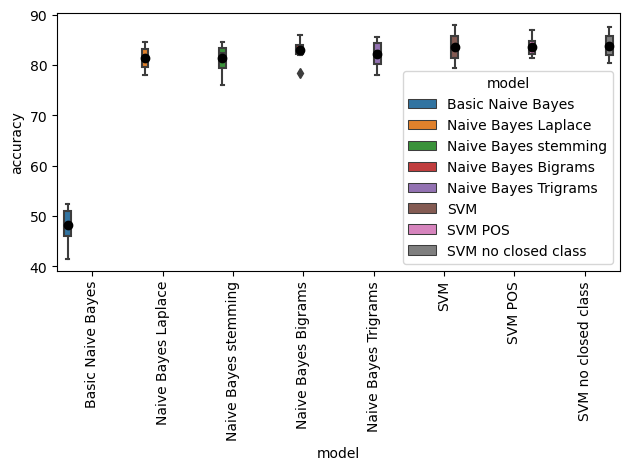

In [125]:
fig = sns.boxplot(data= df_accuracies, y="accuracy", x="model", hue="model",showmeans=True, meanprops={'marker':'o', 'markerfacecolor' : "black", 'markeredgecolor' : "black"})
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

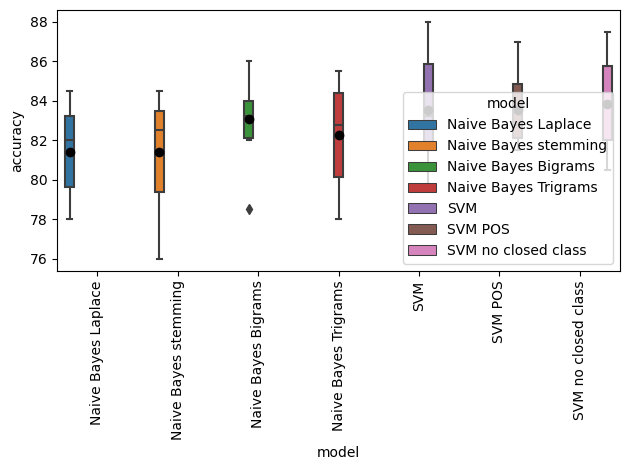

In [205]:
df_accuracies2 = df_accuracies[df_accuracies.model != "Basic Naive Bayes"]
fig = sns.boxplot(data= df_accuracies2, y="accuracy", x="model", hue="model", showmeans=True, meanprops={'marker':'o', 'markerfacecolor' : "black", 'markeredgecolor' : "black"} )
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



## Techniques
From our different experiments, we can conclude that among the three different techniques (the lexicon-based approach, Naive Bayes, and Support Vector Machines), the SVMs obtained the highest average accuracy (around 83%). In contrast, the Lexicon-based approach performed the worst, with a 68.85% accuracy at best (with magnitude measures).

The boxplots above show results for different implementations of the Naive Bayes and SVMs using various techniques and features based on 10-fold cross-validations. The lines in the boxplots show the median, and the boxes themselves show the range of accuracies over the different splits. The black dot represents the mean accuracy. 

*Laplace smoothing*
The basic Naive Bayes classifier without smoothing resulted in an unsatisfactory accuracy below 50%, as it has no proper way of dealing with words it has never seen, causing difficulties in deciding class. Comparatively, the implementation with Laplace smoothing technique showed more promising results: the average accuracy reached around 82%. We should note that assignment 2.3 showed us that it is important to use a balanced dataset when using this technique as an unbalanced dataset decreased the accuracy dramatically. 

### Naive Bayes Features
We manipulated several features when training our Naive Bayes Classifiers.

Firstly, stemming did not cause much of an improvement accuracy-wise. While stemming helped with the dimension reduction for feature vectors, making vectors less sparse so that the system can focus on important features, it may also disregard specific features (i.e. specific word forms) that may be loaded with patterns important for sentiment analysis.

Including bigrams as features did improve the accuracy slightly. Adding bigrams (and trigrams) includes structural information as features, so we are better equipped to deal with direct negations (e.g. *not funny*). However, it does also increase the extent of data sparsity, for instance, there are more unique trigrams in a text than unique bigrams. This might explain why using unigrams+bigrams as features obtained a higher accuracy than using unigrams+bigrams+trigrams.

### SVM features

The basic SVM classifier trained with only words as features achieved an average accuracy of 83.55%, with a relatively big variance and a fold with an accuracy lower than 80%.

Encoding PoS information together with words as features helps to differentiate various semantic functions of the same word form. The system can then grasp patterns by focusing on subsets of word tokens that are really helpful for sentiment analysis. This resulted in a similar accuracy of 83.55%, but the variance is smaller and every fold's accuracy reaches above 80%.

Removing closed-class words also helps to improve the average accuracy slightly, as it can deduct feature dimensions that are not necessary for sentiment analysis.

## Limitations
First of all, the lexicon-based approach heavily depends on the sentiment lexicon used (quality and exhaustiveness). Furthermore, Naive Bayes and SVM (with count vectors as input) both suffer from data sparsity problems and are not good at dealing with unseen words. Using n-grams as features further expands the feature dimension while not all features added would be useful for the task, and the same problem exists for involving PoS information in features. Stemming and removing certain words, on the other hand, bring a tradeoff between reducing feature dimension and retaining information.




# Submission


In [130]:
# Write your names and student numbers here:
# Yunchong Huang #14775875
# Francijn Keur #13133152

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.